# SETUP

In [1]:
import os
import json
from matplotlib.image import imread, imsave
from matplotlib.pyplot import imshow, show, close
from matplotlib import pyplot as plt
from collections import OrderedDict
import math
import matplotlib.image as mpimg
import cv2
import numpy as np
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection, PolyCollection
import matplotlib.transforms as mtrans
import pandas as pd
import seaborn as sns

In [2]:
# uci primary colors
uci_blue = (0/255, 62/255, 120/255)
uci_gold = (253/255, 185/255, 19/255)

# uci secondary color palette
uci_light_blue = (106/255, 162/255, 184/255)
uci_light_gray = (197/255, 190/255, 181/255)
uci_dark_blue = (27/255, 61/255, 109/255)
uci_orange = (247/255, 141/255, 45/255)
uci_light_yellow = (247/255, 235/255, 95/255)
uci_dark_gray = (85/255, 87/255, 89/255)
uci_lime_green = (122/255, 184/255, 0/255)

# color blind friendly colors
# https://gist.github.com/thriveth/8560036
color_blinds = {
    'blue':   [55/255,  126/255, 184/255],  #377eb8 
    'orange': [255/255, 127/255, 0/255],    #ff7f00
    'green':  [77/255,  175/255, 74/255],   #4daf4a
    'pink':   [247/255, 129/255, 191/255],  #f781bf
    'brown':  [166/255, 86/255,  40/255],   #a65628
    'purple': [152/255, 78/255,  163/255],  #984ea3
    'gray':   [153/255, 153/255, 153/255],  #999999
    'red':    [228/255, 26/255,  28/255],   #e41a1c
    'yellow': [222/255, 222/255, 0/255]     #dede00
}  

# EVALUATIONS

In [68]:
# json files output with all string key names
# process so that the evaluation dictionary structure is such:
    # episode # - int
        # step # - int
            # state - dictionary of misc key, value pairs for that state
def process_episodes(json_evaluation):
    nEpisodes = len(json_evaluation) - 1
    episodes = [None] * nEpisodes
    for episode_str in json_evaluation:
        if 'episode_' not in episode_str:
            continue
        episode_num = int(episode_str.split('_')[1]) - 1
        json_episode = json_evaluation[episode_str]
        nSteps = len(json_episode)
        states = [None] * nSteps
        for step_str in json_episode:
            step_num = int(step_str.split('_')[1]) - 1
            state = json_episode[step_str]
            states[step_num] = state
        episodes[episode_num] = states
    return episodes
def read_evaluations(evaluation_folder):
    evaluation_files = [file for file in os.listdir(evaluation_folder)]
    nEvaluations = len(evaluation_files)
    evaluations = [None] * nEvaluations
    for evaluation_file in evaluation_files:
        if '.json' not in evaluation_file:
            continue
        evaluation_number = int(evaluation_file.split('.')[0].split('_')[1])
        json_evaluation = json.load(open(evaluation_folder + evaluation_file, 'r'))
        episodes = process_episodes(json_evaluation)
        evaluations[evaluation_number] = episodes
    return evaluations
# architecture for evaluations:
# evaluations - list of episodes (indexed of evaluation number) - 0 idx is first evaluation before training
    # episodes - list of states (indexed by step number)
        # states - dict of (key, value) pairs for state at all_evaluations[instance][evaluation][episode][step]

In [119]:
# read evaluations from folders
# get these (sub_folder intances)
instances = [
    'mlserver2019', 
    'timpc', 
    'hacknet4', 
    'mlserver2021', 
    'testbed1', 
]
parent_path = 'local/results/'
instances = [folder for folder in os.listdir(parent_path)]
paths = {instance:parent_path + instance + '/evaluations/' for instance in instances}
all_evaluations = {}
for instance in paths:
    all_evaluations[instance] = read_evaluations(paths[instance])

In [80]:
# process evaluations
final_variables = {instance:{} for instance in instances}
for instance in instances:
    for episodes in all_evaluations[instance]:
        for episode, states in enumerate(episodes):
            final_state = states[-1]
            for variable in final_state:
                if variable not in final_variables[instance]:
                    final_variables[instance][variable] = {}
                if episode not in final_variables[instance][variable]:
                    final_variables[instance][variable][episode] = []
                final_variables[instance][variable][episode].append(final_state[variable])
# architecture of final_variables:
# instance - str name
    # variable - str name
        # episode - int number
            # final values - list of final values with increased # of training evaluations 

In [82]:
for instance in instances:
    print(instance)
    print(final_variables[instance].keys())

mlserver2019_DQN
dict_keys(['rl_output', 'nSteps', 'transcribed_action', 'observation_component', 'drone_position', 'yaw', 'has_collided', 'reward_from_AvoidReward', 'reward_from_GoalReward', 'total_reward', 'termination_reason', 'termination_result', 'done'])


total_reward
mlserver2019_DQN


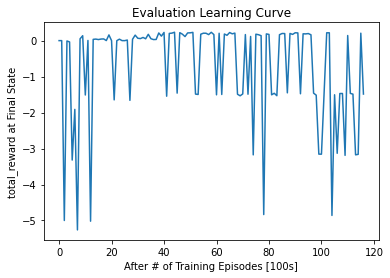

termination_reason
mlserver2019_DQN


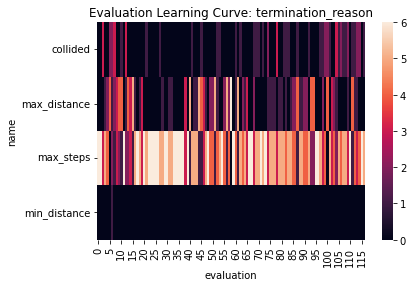

In [88]:

# select which state variables to fetch
numerical_variables = [
        #'nSteps', 
        'total_reward', 
]
string_variables = [
    #'transcribed_action', 
    'termination_reason',
]
all_variables = numerical_variables + string_variables
plots = {}
# take mean values
for variable in all_variables:
    plots[variable] = {}
    print(variable)
    for instance in instances:
        plots[variable][instance] = {}
        print(instance)
        
        values = {}
        for episode in final_variables[instance][variable]:
            for evaluation in range(len(final_variables[instance][variable][episode])):
                if evaluation not in values:
                    values[evaluation] = []
                values[evaluation].append(final_variables[instance][variable][episode][evaluation])

        if variable in numerical_variables:
            aggregates = []
            nEpisodes = len(final_variables[instance][variable])
            for evaluation in values:
                aggregates.append(sum(values[evaluation])/len(values[evaluation]))
            plt.title('Evaluation Learning Curve')
            plt.xlabel('After # of Training Episodes [100s]')
            plt.ylabel(variable + ' at Final State')
            plt.plot(aggregates)
            plt.show()

        if variable in string_variables:
            aggregates = {}
            for evaluation in values:
                for name in values[evaluation]:
                    if name not in aggregates:
                        aggregates[name] = {}
                    if evaluation not in aggregates[name]:
                        aggregates[name][evaluation] = 0
                    aggregates[name][evaluation] += 1   
            df_data = {'count':[], 'name':[], 'evaluation':[]}
            for name in aggregates:
                for evaluation in values:
                    if evaluation not in aggregates[name]:
                        aggregates[name][evaluation] = 0
                    count = aggregates[name][evaluation]
                    df_data['count'].append(count)
                    df_data['name'].append(name)
                    df_data['evaluation'].append(evaluation)
            df = pd.DataFrame(df_data)
            heatmap_data = pd.pivot_table(df, values='count', index=['name'], columns='evaluation')
            sns.heatmap(heatmap_data)
            plt.title('Evaluation Learning Curve: ' + variable)
            plt.show()
            
        plots[variable][instance] = aggregates

In [117]:
# view moves for each evaluation for each episode
for instance in instances:
    for evaluation, episodes in enumerate(all_evaluations[instance]):
        for episode, states in enumerate(episodes):
            print('Instance', instance, 'Evaluation', evaluation, 'Episode', episode)
            for state in states:
                action = state['transcribed_action']
                marker = '-'
                if 'RotateLeft' in action:
                    marker = 'L'
                if 'RotateRight' in action:
                    marker = 'R'
                if action == 'MoveForward':
                    marker = 'F'
                print(marker, end=' ')
            print()

Instance mlserver2019_DQN Evaluation 0 Episode 0
L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L 
Instance mlserver2019_DQN Evaluation 0 Episode 1
L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L 
Instance mlserver2019_DQN Evaluation 0 Episode 2
L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L 
Instance mlserver2019_DQN Evaluation 0 Episode 3
L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L 


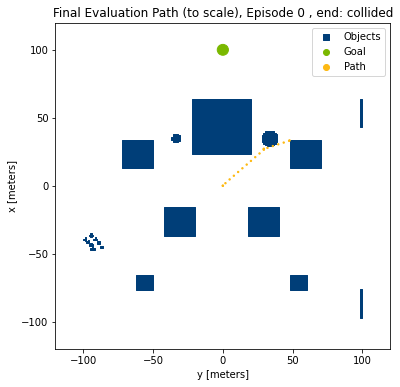

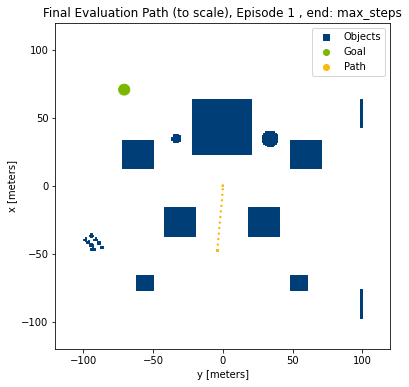

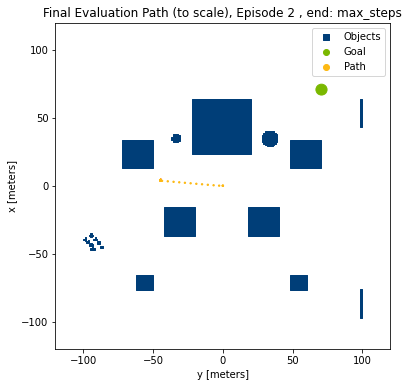

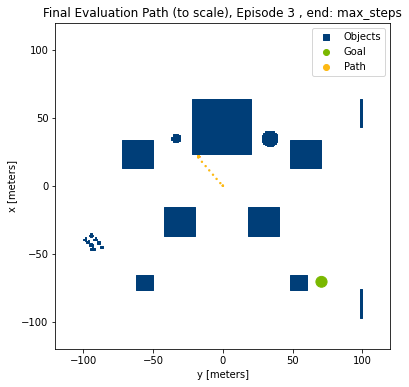

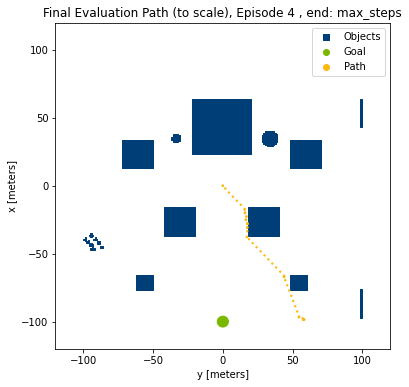

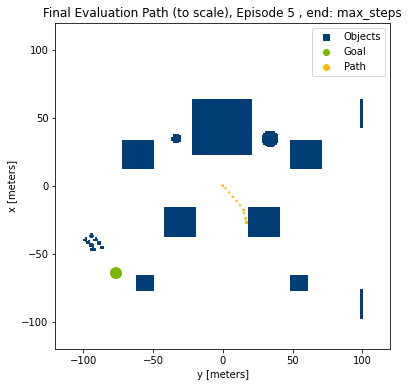

In [126]:
# plot final paths (run necessary binvox stuff at bottom of notebook to use plot_map)
for instance in instances:
    nEpisodes = 6 
    last_ls = {}
    last_xs = {}
    last_ys = {}
    last_zs = {}
    obj_xs = []
    obj_ys = []
    termination_reasons = []
    episodes = all_evaluations['mlserver2019_DQN'][-1]
    for episode in range(nEpisodes):
        last_ls[episode] = []
        last_xs[episode] = []
        last_ys[episode] = []
        last_zs[episode] = []
        first_position = episodes[episode][0]['drone_position']

        yaw = [math.radians(0), 
               math.radians(-45), 
               math.radians(45), 
               math.radians(135), 
               math.radians(180), 
               math.radians(230)][episode]
        obj_distance = 100
        obj_x = obj_distance * math.cos(yaw)
        obj_y = obj_distance * math.sin(yaw)
        obj_xs.append(obj_x)
        obj_ys.append(obj_y)

        for step in range(len(episodes[episode])):
            state = episodes[episode][step]
            position = state['drone_position']
            line_distance = math.sqrt((position[0] - first_position[0])**2 + (position[1] - first_position[1])**2)
            last_ls[episode].append(line_distance)
            last_xs[episode].append(position[0])
            last_ys[episode].append(position[1])
            last_zs[episode].append(position[2])
        termination_reason = episodes[episode][-1]['termination_reason']
        termination_reasons.append(termination_reason)
    object_color = uci_blue
    goal_color = uci_lime_green
    path_color = uci_gold
    for idx, episode in enumerate(last_ls):
        fig = plt.figure()
        fig.set_size_inches((6, 6))
        plt.title('Final Evaluation Path (to scale), Episode ' + str(episode) + ' , end: ' + termination_reasons[idx])
        # custom legend hack
        plt.scatter(-999, -999, marker='s', color=object_color)
        plt.scatter(-999, -999, color=goal_color)
        plt.scatter(-999, -999, color=path_color)
        plt.legend(['Objects', 'Goal', 'Path'])
        plot_map(object_color)
        obj = plt.Circle((obj_ys[idx], obj_xs[idx]), 4, color=goal_color)
        plt.gca().add_patch(obj)
        plt.xlabel('y [meters]')
        plt.ylabel('x [meters]')
        plt.xlim(-120, 120)
        plt.ylim(-120, 120)
        for idx in range(len(last_ys[episode])):
            # using generic quad copter dimensions for point sizes (set this to your drone value)
            radius = 0.5
            point = plt.Circle((last_ys[episode][idx], last_xs[episode][idx]), radius, color=path_color)
            plt.gca().add_patch(point)
        plt.show()

In [ ]:
# make a slide show video from observations and states
last_evaluation = list(evaluations.keys())[-1]
last_evaluations = evaluations[last_evaluation]
observations = {}
state_variables = {}
for episode in last_evaluations:
    observations[episode] = []
    state_variables[episode] = []
    previous_state = last_evaluations[episode]['1']
    first_position = last_evaluations[episode]['1']['drone_position']
    for step in last_evaluations[episode]:
        
        observation = previous_state['observation_component']
        observations[episode].append(observation)
        
        state = last_evaluations[episode][step]
        action = state['transcribed_action']
        reward = state['total_reward']
        state_vars = {
            'Action' : action,
            'Reward' : reward,
        }
        state_variables[episode].append(state_vars)
        
        previous_state = state
        
    state = last_evaluations[episode][str(len(last_evaluations[episode]))]
    observation = state['observation_component']
    observations[episode].append(observation)
    reward = state['total_reward']
    state_vars = {
            'Action' : 'done ' + state['termination_reason'],
            'Reward' : reward,
        }
    state_variables[episode].append(state_vars)
    
# make slideshow frames
font_dic = {'color':'orange', 
            'size':18, 
           }
offset = -2
y = 4
inc = 8
for episode in last_evaluations:
    print('Episode', episode)
    for step, observation in enumerate(observations[episode]):
        if step == 0:
            continue
        splits = observation.split('_')
        vec = json.load(open(observation_folder + splits[1] + '.json', 'r'))
        img = mpimg.imread(observation_folder + splits[2] + '.png')
        plt.title('Step ' + str(step))
        plt.imshow(img)
        plt.text(0, y + inc, 'Action: ' + str(state_variables[episode][step]['Action']), font_dic)
        plt.text(0, y + 2*inc, 'Reward: ' + str(round(state_variables[episode][step]['Reward'],2)), font_dic)
        for idx, key in enumerate(vec):
            val = vec[key]
            if key == 'yaw_difference_normalized':
                key = 'Yaw_Diff'
                val = int(360 * (1 - val))
            plt.text(0, y + (idx + 3)*inc, key + ': ' + str(val) + '\N{DEGREE SIGN}', font_dic)
        plt.show()
        plt.savefig(slideshow_path + episode + '_' + str(step) + '.png')
        
# make video from frames
for episode in last_evaluations:
    frames = []
    for step, observation in enumerate(observations[episode]):
        if step == 0:
            continue
        frame_path = slideshow_path + episode + '_' + str(step) + '.png'
        frame = cv2.imread(frame_path)
        frame_shape = frame.shape
        frames.append(frame)
        print(type(frame), frame.shape)
    video_path = slideshow_path + 'Final_Evaluation_Episode_' + episode + '.avi'
    video = cv2.VideoWriter(
                            filename = video_path, 
                            fourcc = 0,
                            fps = 1,
                            frameSize = (frame_shape[1], frame_shape[0]),
                            isColor = True,
                           )
    for frame in frames:
        video.write(frame)
    video.release()

# OBSERVATOINS

In [ ]:
observation_folder = ''
observations = {}
observation_files = [file for file in os.listdir(observation_folder)]
for observation_file in observation_files:
    observation_name = observation_file.split('.')[0]
    observations[observation_name] = imread(observation_folder + observation_file)
imshow(observations[observation_name], cmap='gray')

# BENCHMARKS

In [121]:
benchmarks_path = ''
benchmarks = json.load(open(benchmarks_path, 'r'))
print('Estimated Time of Completion:', sum(benchmarks['time']['environments.dronerl.reset']) / 1_000_000 / 60 / 60)

NameError: name 'benchmarks_path' is not defined

In [ ]:
def aggregate_time_benchmarks(benchmarks):
    aggregated = {'units':benchmarks['time']['units']}
    for variable_name in benchmarks['time']:
        if variable_name == 'units':
            continue
        if variable_name in ['maps.airsimmap.connect', ]:
            method_name = variable_name
        else:
            method_name = variable_name.split('.')[-1]
        if method_name not in aggregated:
            aggregated[method_name] = []
        aggregated[method_name] = aggregated[method_name] + benchmarks['time'][variable_name]
    return aggregated
def aggregate_memory_benchmarks(benchmarks):
    aggregated = {'units':benchmarks['memory']['units']}
    for variable_name in benchmarks['memory']:
        if variable_name == 'units':
            continue
        class_name = variable_name.split('_')[0]
        if class_name not in aggregated:
            aggregated[class_name] = []
        aggregated[class_name] = aggregated[class_name] + benchmarks['memory'][variable_name]
    return aggregated
def visualize_benchmarks(benchmarks):
    for metric_name in benchmarks:
        units = benchmarks[metric_name]['units']
        for variable_name in benchmarks[metric_name]:
            if variable_name in ['units', 'memory']:
                continue
            measurements = benchmarks[metric_name][variable_name]
            plt.hist(measurements, 10)
            plt.xlabel(metric_name + ' [' + units + ']')
            plt.ylabel('Bin Count')
            plt.title(variable_name)
            plt.show()
benchmarks['time'] = aggregate_time_benchmarks(benchmarks)
#benchmarks['memory'] = aggregate_memory_benchmarks(benchmarks)
visualize_benchmarks(benchmarks)

# BINVOX

In [104]:
import binvox as bv
binvox_path = 'resources/voxel_grids/blocksmap.binvox'
voxels = bv.Binvox.read(binvox_path, 'dense')
voxels_data = voxels.data
voxels_scale = voxels.scale 
voxels_trans = voxels.translate
voxels_res = (np.absolute(trans)) * 2 * scale

In [102]:
def plot_map(object_color=uci_blue):
    origin = voxels_data[int(voxels_data.shape[1]/2), int(voxels_data.shape[0]/2), :]
    floor_dim = max([i for i, x in enumerate(origin) if x])
    scale = voxels_scale * 100
    shift = 100
    plt_patches = []
    for x in range(voxels_data.shape[0]):
        for y in range(voxels_data.shape[1]):
            for z in range(voxels_data.shape[2]):
                if voxels_data[x, y, z] and z > floor_dim:
                    #x_loc = x - shift - scale/2 # align to left for plt.rect
                    #y_loc = y - shift - scale/2 # align to bottom for plt.rect
                    #patch = patches.Rectangle((x_loc, y_loc), scale, scale, color = object_color)
                    patch = patches.Rectangle((x-shift, y-shift), 1, 1, color = object_color)
                    plt_patches.append(patch)
                    break
    # add list of patches (much quicker than iteratively drawing)
    collection = PatchCollection(plt_patches, match_original=True)
    plt.gca().add_collection(collection)

In [106]:
def plot_spawns_goals(
    drone_radius = 0.5,
    goal_tolerance = 4,
    goal_distance = 100,
    spawns = [],
    goals = [],
    spawn_color = color_blinds['red'],
    goal_color = color_blinds['orange'],
    goal_wedge = True,
):
    # patch stuff
    spawn_patches = []
    goal_patches = []
    for idx in range(len(spawns)):
        spawn = spawns[idx]
        goal = goals[idx]
        spawn_patch = patches.Rectangle(
            (spawn[0], spawn[1]), 
            drone_radius, 
            drone_radius, 
            color=spawn_color,
        )
        spawn_patches.append(spawn_patch)
        if goal_wedge:
            radius = math.sqrt(goal[0]**2 + goal[1]**2)
            goal_patch = patches.Wedge(
                (spawn[0], spawn[1]), 
                goal_distance+goal_tolerance, 
                goal[0], goal[1], 
                width=2*goal_tolerance,
                color=goal_color,
            )
        else:
            goal_patch = patches.Circle(
                (goal[0], goal[1]), 
                goal_tolerance, 
                color=goal_color,
            )
        goal_patches.append(goal_patch)
    # add list of patches (much quicker than iteratively drawing)
    spawn_collection = PatchCollection(spawn_patches, match_original=True)
    goal_collection = PatchCollection(goal_patches, match_original=True)
    plt.gca().add_collection(goal_collection)
    plt.gca().add_collection(spawn_collection)

In [107]:
def plot_environment(name='Learning Environment (to scale)'):
    fig = plt.figure()
    fig.set_size_inches((6, 6))
    plt.title(name)
    plt.xlabel('y [meters]')
    plt.ylabel('x [meters]')
    plt.xlim(-120, 120)
    plt.ylim(-120, 120)
    # custom legend hack
    plt.scatter(-999, -999, marker='s', color=object_color)
    plt.scatter(-999, -999, marker='s', color=train_spawn_color)
    plt.scatter(-999, -999, color=train_goal_color)
    #plt.scatter(-999, -999, color=eval_spawn_color)
    #plt.scatter(-999, -999, color=eval_goal_color)
    plt.legend([
        'Objects', 
        'Spawn', 
        'Goal', 
        #'Eval Spawn', 
        #'Eval Goal'
    ],
               loc='center left', 
               bbox_to_anchor=(1, 0.5),)

In [108]:
object_color = color_blinds['blue']
train_spawn_color = color_blinds['red']
train_goal_color = color_blinds['orange']
eval_spawn_color = color_blinds['pink']
eval_goal_color = color_blinds['purple']
drone_radius = 0.5
goal_tolerance = 4
goal_distance = 100

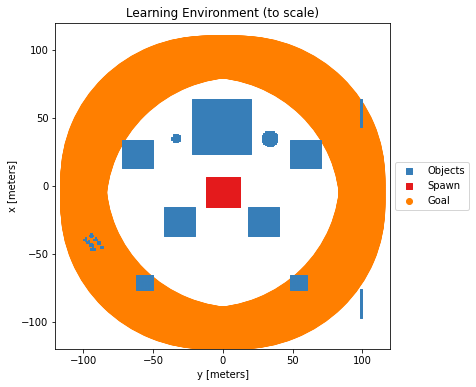

In [110]:
# plot phase blocks environment map
name='Learning Environment (to scale)'
goal_distance = 100

# set training spawns and goals
x_min = -16
x_max = 6
y_min = -12
y_max = 12
yaw_min = 0
yaw_max = 360
training_spawns = []
training_goals = []
for x in np.arange(x_min, x_max + drone_radius, drone_radius):
    for y in np.arange(y_min, y_max + drone_radius, drone_radius):
        training_spawns.append([y, x])
        training_goals.append([yaw_min, yaw_max])
        
# set evaluation spawns and goals
evaluation_vecs = [
    [0,0,math.radians(0)],
    [0,0,math.radians(135)],
    [0,0,math.radians(180)],
    [0,0,math.radians(230)],
]
evaluation_spawns = []
evaluation_goals = []
for eval_vec in evaluation_vecs:
    x = eval_vec[0]
    y = eval_vec[1]
    yaw = eval_vec[2]
    evaluation_spawns.append([y, x])
    goal_x = goal_distance * math.cos(yaw)
    goal_y = goal_distance * math.sin(yaw)
    evaluation_goals.append([goal_y, goal_x])
    
# make plot
plot_environment(name)

# plot training spawns and goals
plot_spawns_goals(
    drone_radius = drone_radius,
    goal_tolerance = goal_tolerance,
    goal_distance = goal_distance,
    spawns = training_spawns,
    goals = training_goals,
    spawn_color = train_spawn_color,
    goal_color = train_goal_color,
    goal_wedge = True,
)

# plot map objects
plot_map(object_color)

# plot evaluation  spawns and goals
'''
plot_spawns_goals(
    drone_radius = drone_radius,
    goal_tolerance = goal_tolerance,
    goal_distance = goal_distance,
    spawns = evaluation_spawns,
    goals = evaluation_goals,
    spawn_color = eval_spawn_color,
    goal_color = eval_goal_color,
    goal_wedge = False,
)
'''

# show all
plt.show()